In [1]:
import scanpy as sc
adata_hvg = sc.read("data/dataset_glutamatergic_latest_state.h5ad")

In [2]:
import pertpy as pt

milo = pt.tl.Milo()
mdata = milo.load(adata_hvg)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
neighbours = 46 * 5
sc.pp.neighbors(adata_hvg, n_neighbors=neighbours, use_rep="X_scVI", key_added="milo")

In [51]:
import numpy as np

milo.make_nhoods(mdata, neighbors_key="milo", prop=0.02)
adata_hvg.obsm["nhoods"]
nhood_size = adata_hvg.obsm["nhoods"].toarray().sum(0)
np.median(nhood_size)

np.float32(502.0)

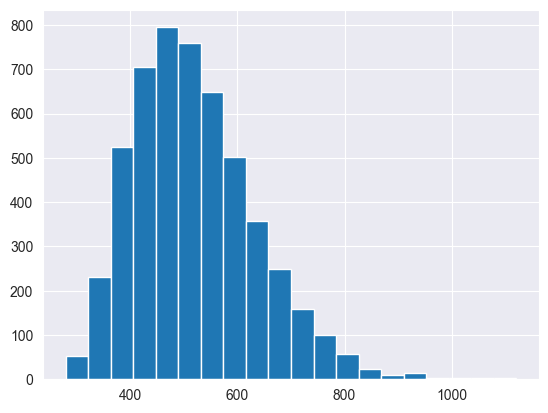

In [45]:
import matplotlib.pyplot as plt
plt.hist(nhood_size, bins=20)
plt.show()

In [52]:
milo.count_nhoods(mdata, sample_col="donor_id")

MuData object with n_obs × n_vars = 282930 × 5000
  2 modalities
    rna:	282930 x 5000
      obs:	'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Author_Annotation_colors', 'cell_type_colors', 'citation', 'disease_colors', 'donor_id_colors', 'hvg', 'neighbors', 'nhood_neighbors_key', 'organism', 'organism_ontology_term_id', 'pca', 'schema_reference', 'schema_version', 'title', 'umap', 'milo'
      obsm:	'X_pca', 'X_pca_harmony', 'X_scVI', 'X_umap', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'spliced', 'unspliced'
      obsp:	'connectivities', 'distances', 'milo_distances', 'milo_connectivities'
    milo:	46 x 11747
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

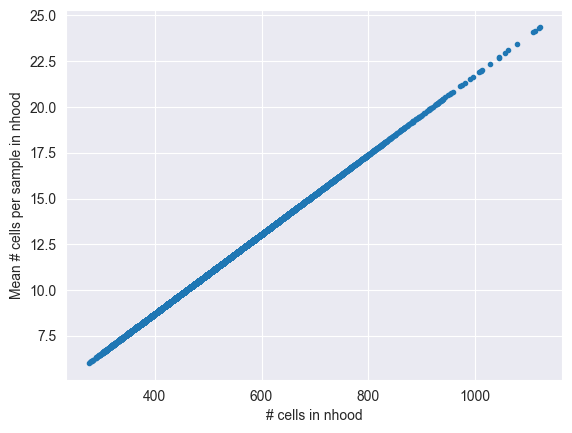

In [53]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [54]:
adata_hvg.obs["disease"].value_counts()

disease
Alzheimer_disease    207990
normal                74940
Name: count, dtype: int64

In [55]:
adata_hvg.obs["disease"].unique()
adata_hvg.obs["disease"] = adata_hvg.obs["disease"].str.replace(" ", "_")


               disease donor_id
12   Alzheimer_disease       12
14   Alzheimer_disease       14
18   Alzheimer_disease       18
19   Alzheimer_disease       19
24   Alzheimer_disease       24
30   Alzheimer_disease       30
32   Alzheimer_disease       32
33   Alzheimer_disease       33
35   Alzheimer_disease       35
42   Alzheimer_disease       42
44   Alzheimer_disease       44
45   Alzheimer_disease       45
46   Alzheimer_disease       46
49              normal       49
50              normal       50
52   Alzheimer_disease       52
57   Alzheimer_disease       57
59   Alzheimer_disease       59
60   Alzheimer_disease       60
68   Alzheimer_disease       68
69   Alzheimer_disease       69
71              normal       71
73   Alzheimer_disease       73
74   Alzheimer_disease       74
75   Alzheimer_disease       75
76   Alzheimer_disease       76
91              normal       91
92   Alzheimer_disease       92
94              normal       94
95              normal       95
103     

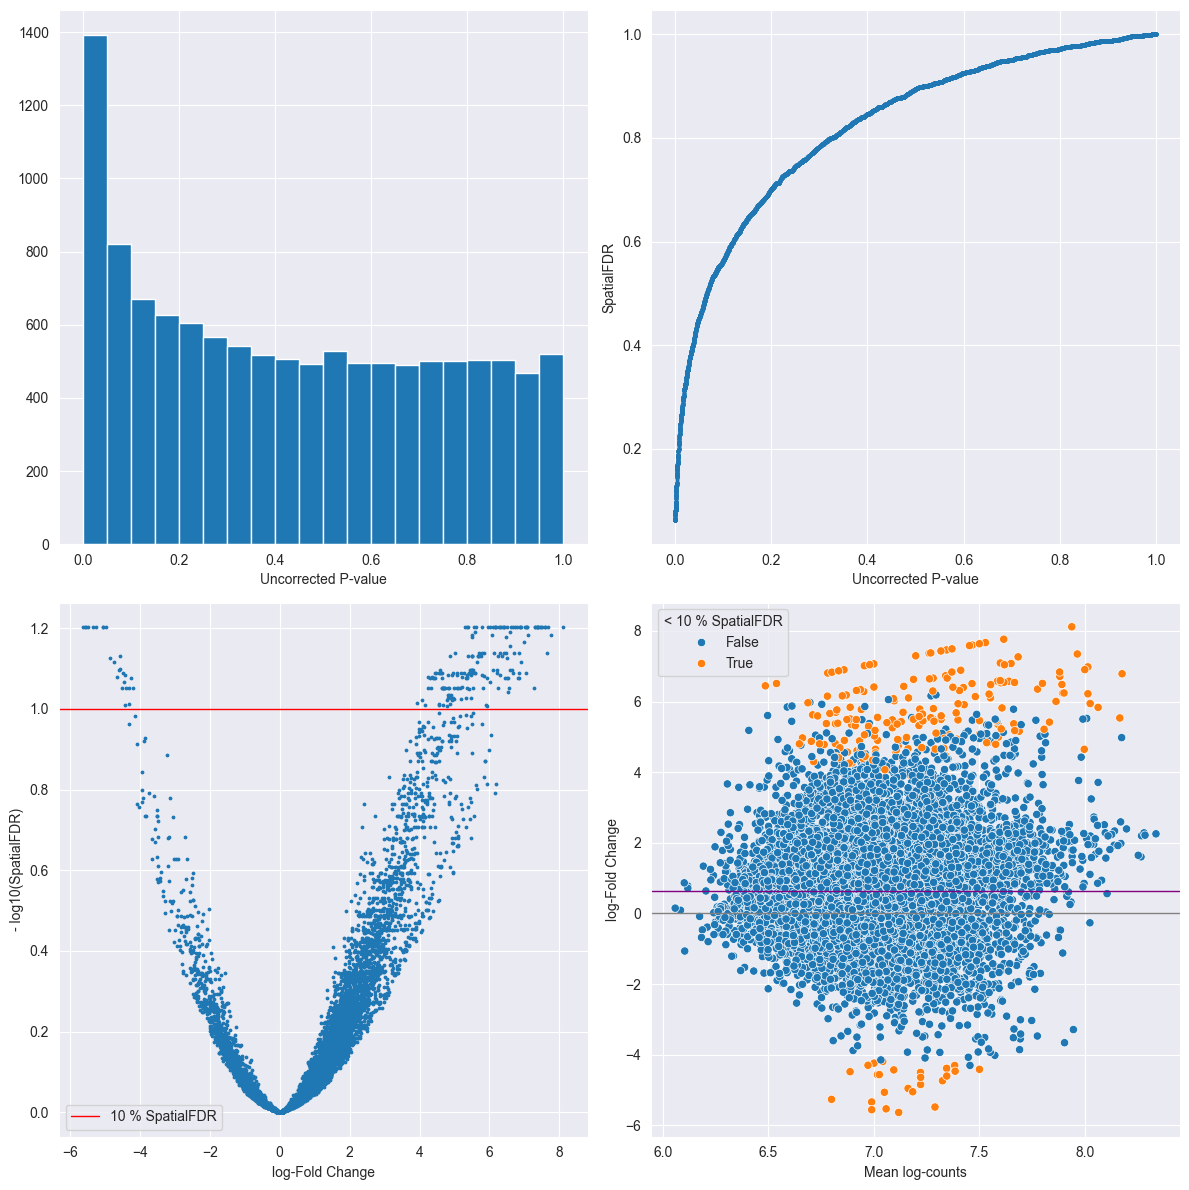

In [56]:
import matplotlib
import seaborn as sns

milo.da_nhoods(
    mdata,
    design="~disease",
    model_contrasts="diseaseAlzheimer_disease - diseasenormal"
)

ds = mdata["milo"].obs.copy()
print(ds)
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):
        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


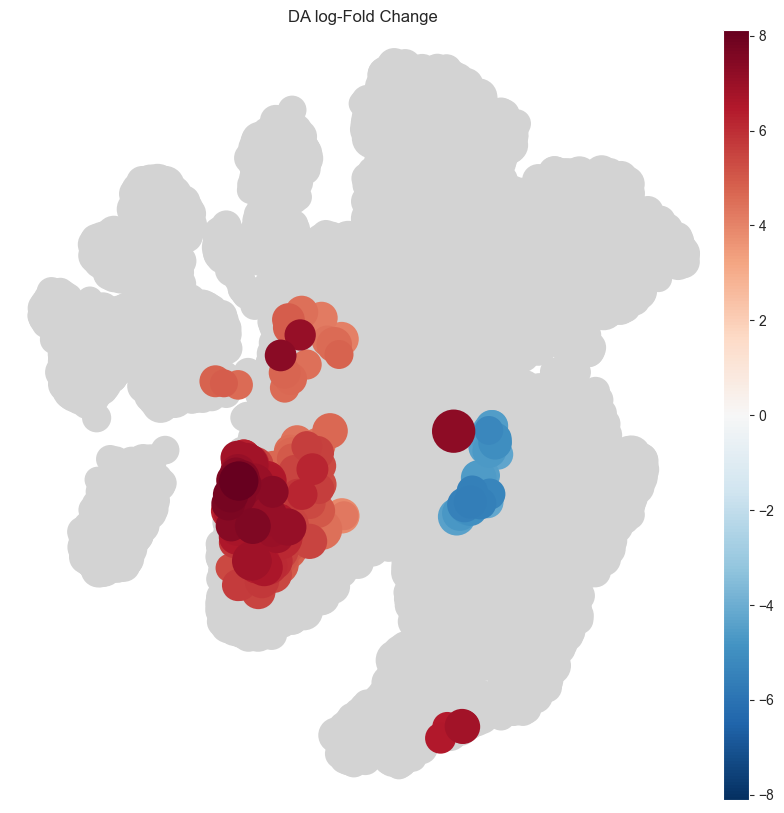

In [57]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)

MuData object with n_obs × n_vars = 282930 × 5000
  2 modalities
    rna:	282930 x 5000
      obs:	'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Author_Annotation_colors', 'cell_type_colors', 'citation', 'disease_colors', 'donor_id_colors', 'hvg', 'neighbors', 'nhood_neighbors_key', 'organism', 'organism_ontology_term_id', 'pca', 'schema_reference', 'schema_version', 'title', 'umap', 'milo'
      obsm:	'X_pca', 'X_pca_harmony', 'X_scVI', 'X_umap', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'spliced', 'unspliced'
      obsp:	'connectivities', 'distances', 'milo_distances', 'milo_connectivities'
    milo:	46 x 5235
      obs:	'disease', 'donor_id'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'adjust.method', 'comparison', 'test', 'SpatialFDR', 'Sig', 'Nhood_size'
      uns:	'sample_col', 'nhood'
      varm:	'X_milo_graph'
      varp:	'nhood_connectivities'